# Collaborative filtering using graphical models

In the Yelp dataset, consider each restaurant r to have a latent trait t_r, let each user u have a latent preference pu, let the user’s experience at a restaurant be X_u,r = Normal(t_r * p_u, 1), and suppose the user gives a rating of
two or more stars if X_u,r > 0. Use Gibbs sampling to learn the latent variables t_r and p_u.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io, scipy.stats, scipy.linalg
import pandas as pd
import collections
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")


In [ ]:
# Generate synthetic dataset 
R = 5
U = 20
reviews = list()

for user in range(U):
    num = np.random.choice(range(2, 4), 1)
    num = num[0]
    restaurants = np.random.choice(R, num, replace=False)
    for restaurant in restaurants:
        rating = np.random.choice([1, 2, 3, 4, 5], 1)
        reviews = reviews + [[user, restaurant, rating[0]]]

N = len(reviews)
reviews = np.array(reviews)

# Process Yelp Dataset

In [ ]:
# Import dataset
reviews_df = pd.read_csv("Users200reviews/reviews.csv")
users_df = pd.read_csv("Users200reviews/users.csv")
restaurants_df = pd.read_csv("Users200reviews/business.csv")


In [ ]:
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)
R = restaurants_df.values.shape[0]
U = users_df.values.shape[0]

print (R)
print (U)

In [ ]:
reviews = np.array(reviews_df[['user_id', 'business_id', 'stars']].values)

for review in reviews:
    review[0] = users_df.index[users_df.id == review[0]].values[0]
    review[1] = restaurants_df.index[restaurants_df.id == review[1]].values[0]
reviews = reviews.astype(int)

In [ ]:
reviews.shape

In [ ]:
train_reviews = reviews[:10000]
test_reviews = reviews[10000:]

# Visualize data

Distribution of the stars given by the users in the chosen dataset. 

In [ ]:
from scipy import stats, integrate

plt.style.use('seaborn')
sns.set_style("whitegrid")
x = [1, 2, 3, 4, 5]

counter = collections.Counter(reviews_df['stars'].values)
plt.bar(x,  [counter[1], counter[2], counter[3], counter[4], counter[5]])

plt.xlabel('star rating', fontsize='x-large')
plt.ylabel('count', fontsize='x-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.savefig("stars_count.pdf")
plt.show()

In [ ]:

counter[1]

# Modeling a single trait and a binary outcome

In [ ]:
def rejection_sampling(mu, std, rating):
    if rating>3:
        sign = 1
    else: 
        sign = -1
    while True:
        x = np.random.normal(loc=mu, scale=std)
        if np.sign(x)==sign:
            return x

In [ ]:
def Gibbs_sampling_single_trait_binary_rating(reviews):

    pv_t = np.ones(R)   # prior variance for restaurant traits
    t = np.zeros(R)     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = np.ones(U)   # prior variance for user preferences
    p = np.zeros(U)     # user preferences, initialized to be the prior mean mu_0 = 0

    x = np.zeros(reviews.shape[0]) 
    
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(3500):
        
        if num%250==0:
            print (num)
        
        # Sample user experience (x) given user preferences (p), restaurant traits (t) and rating (y)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling(s, 1, reviews[r][2])
            
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))

        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return restaurant_traits_samples, user_preferences_samples

In [ ]:
single_trait_restaurant_traits_samples, single_trait_user_preferences_samples = Gibbs_sampling_single_trait_binary_rating(train_reviews)

In [ ]:
plt.style.use('default')
#sns.set_style("white")
mean_traits = np.mean(single_trait_restaurant_traits_samples[50:], axis=0)
mean_preferences = np.mean(single_trait_user_preferences_samples[50:], axis=0)

with matplotlib.rc_context({'figure.figsize': [8,5], 'xtick.labelsize': 12, 'ytick.labelsize': 12}):
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    #ax.set_xlabel(fontsize='20')
    ax.yaxis.set_ticks_position('left')

    
    
    plt.scatter(mean_preferences, np.zeros(U), color=sns.xkcd_rgb["medium green"], label='Users')
    plt.scatter(mean_traits, np.zeros(R), color=sns.xkcd_rgb["pale red"], label = 'Restaurants')
    plt.xlim([-2, 2])
    plt.ylim([-1, 1])
    
    ax.annotate('Raku', fontsize='large', 
                xy=(mean_traits[east],0), xytext=(1.5, -0.5), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('Umami Burger', fontsize='large',
                xy=(mean_traits[west],0), xytext=(-2, 0.5), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('Citizens Kitchen', fontsize='large',
                xy=(mean_traits[north],0), xytext=(0.2, 0.8), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    
    ax.annotate('KoMex Fusion', fontsize='large',
                xy=(mean_traits[north_east],0), xytext=(0.75, 0.5), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('Brasserie', fontsize='large',
                xy=(mean_traits[south_west],0), xytext=(-0.9, -0.5), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    
    
    plt.legend(loc='lower right', fontsize='x-large')

    
plt.savefig('single_trait_restaurants.pdf')    
plt.show()

# Burn-in time for Gibbs sampler

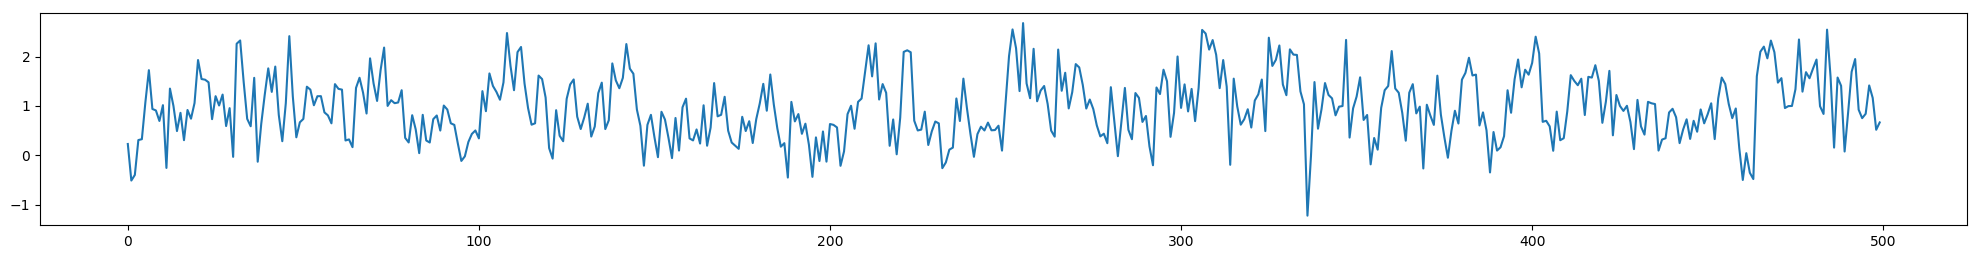

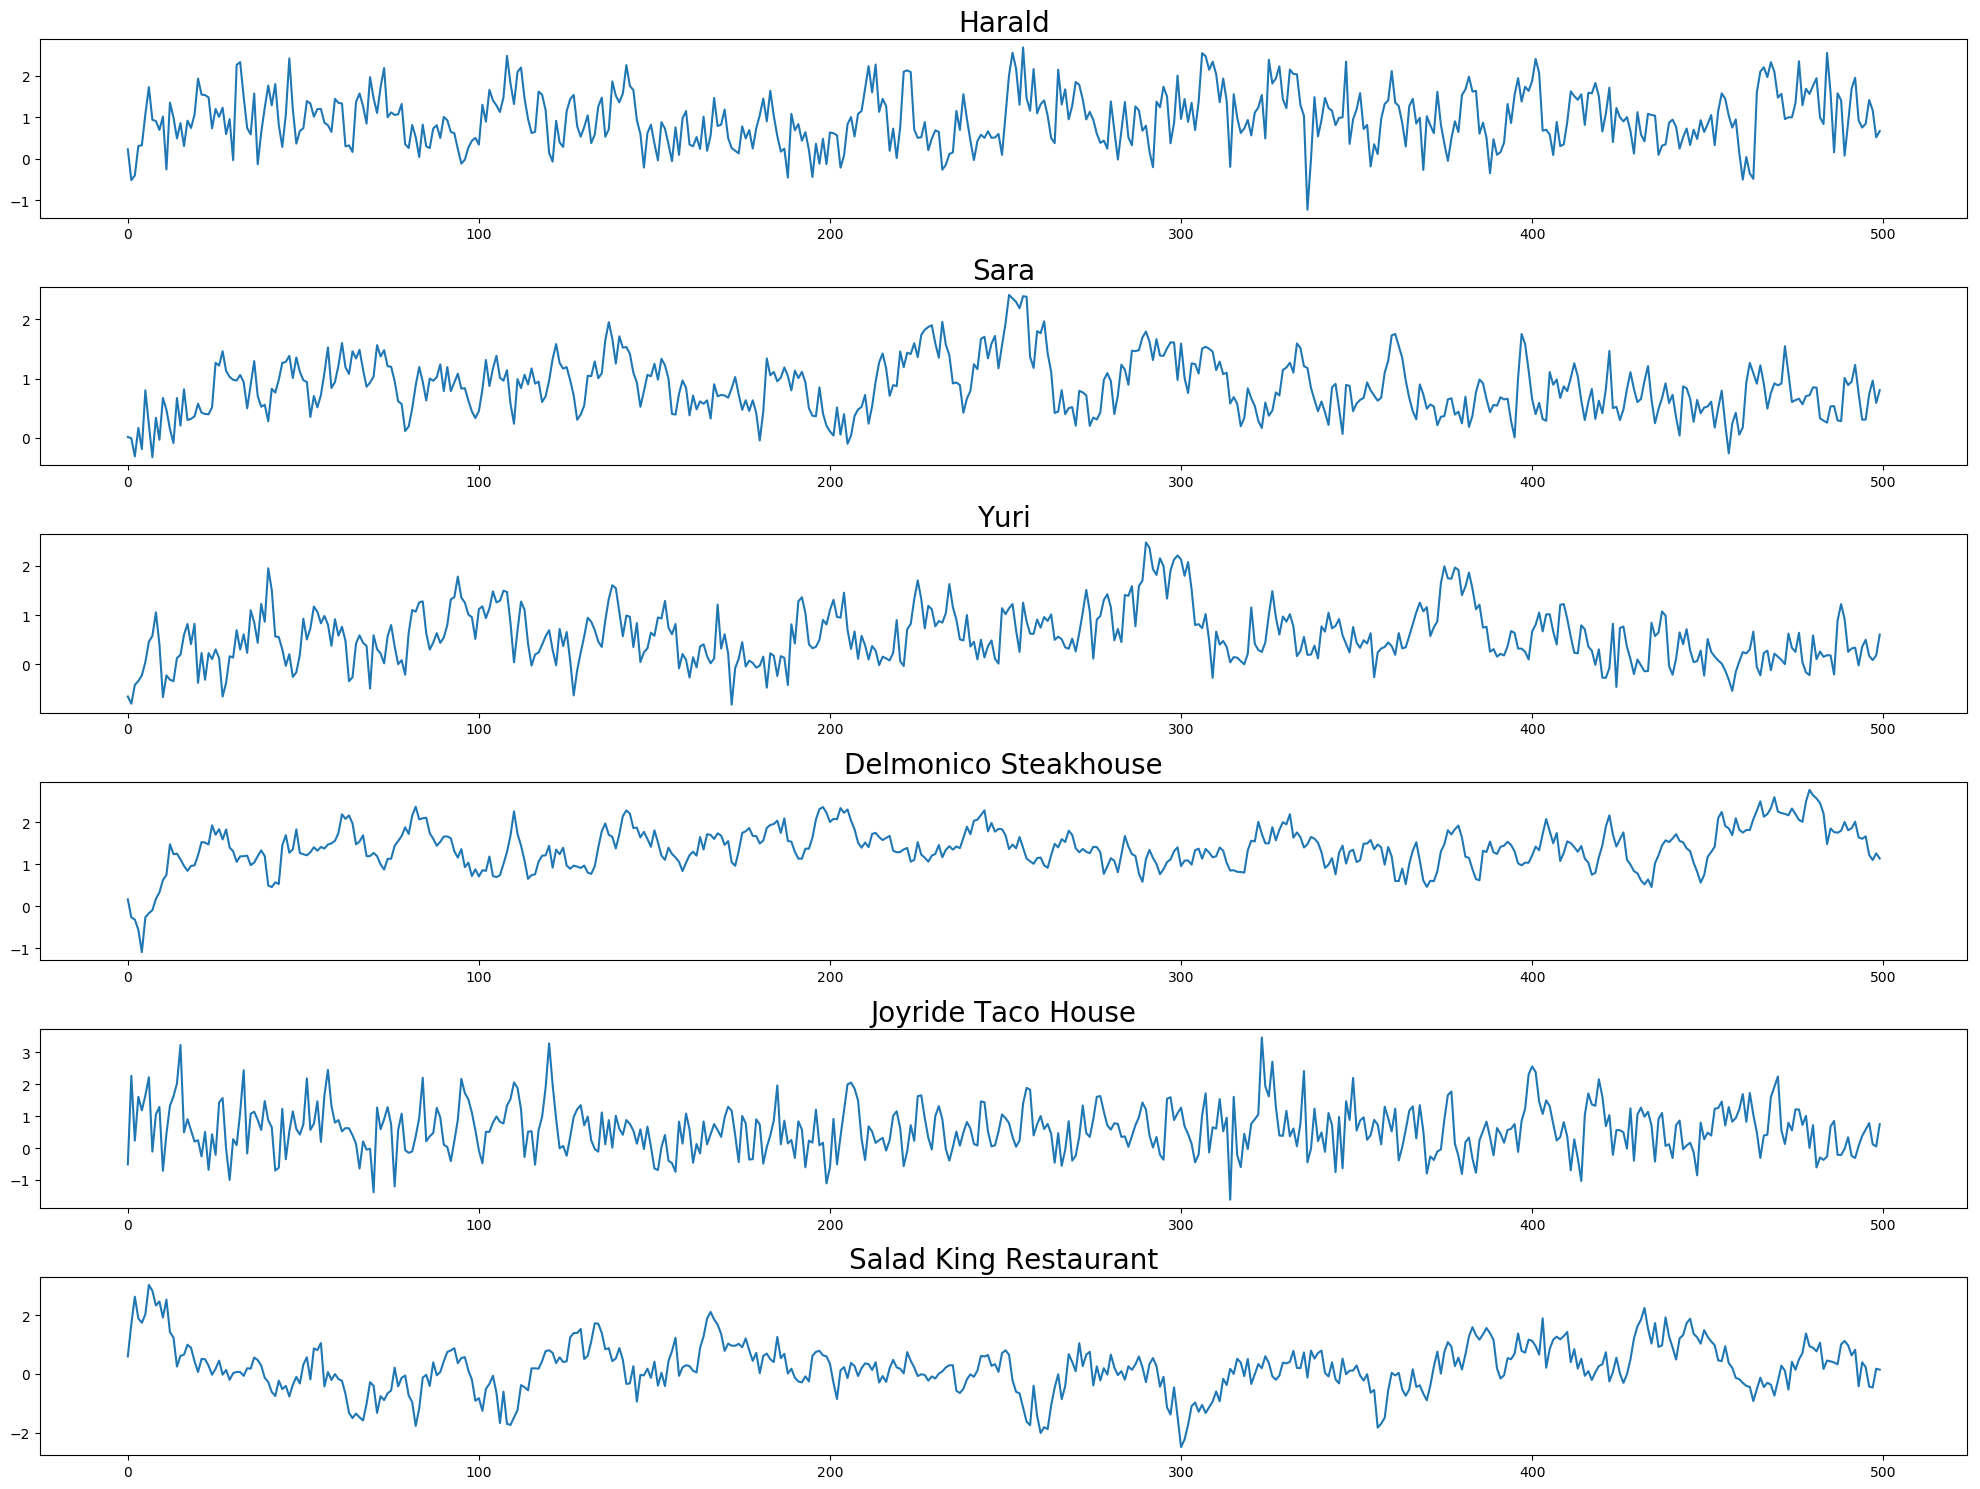

In [395]:
users = [0, 1, 2]
restaurants = [0, 1, 2]

with matplotlib.rc_context({'figure.figsize': [20,15], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+1)
        fig.tight_layout()
        fig.tight_layout()
        ax.plot(single_trait_user_preferences_samples[:500, users[i]])
        ax.set_title(users_df.get_value(users[i], 'name'))
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+4)
        fig.tight_layout()
        ax.plot(single_trait_restaurant_traits_samples[:500, restaurants[i]])
        ax.set_title(restaurants_df.get_value(restaurants[i], 'name'))
plt.show()

The burning time represents the time required to get from the initial random location in the Gibbs sampler to a location that has a high probability under the posterior. By looking at the user preferences and restaurant traits for each iteration we can notice that the burning time is about 40 iterations. 

# Mixing time for Gibbs sampler

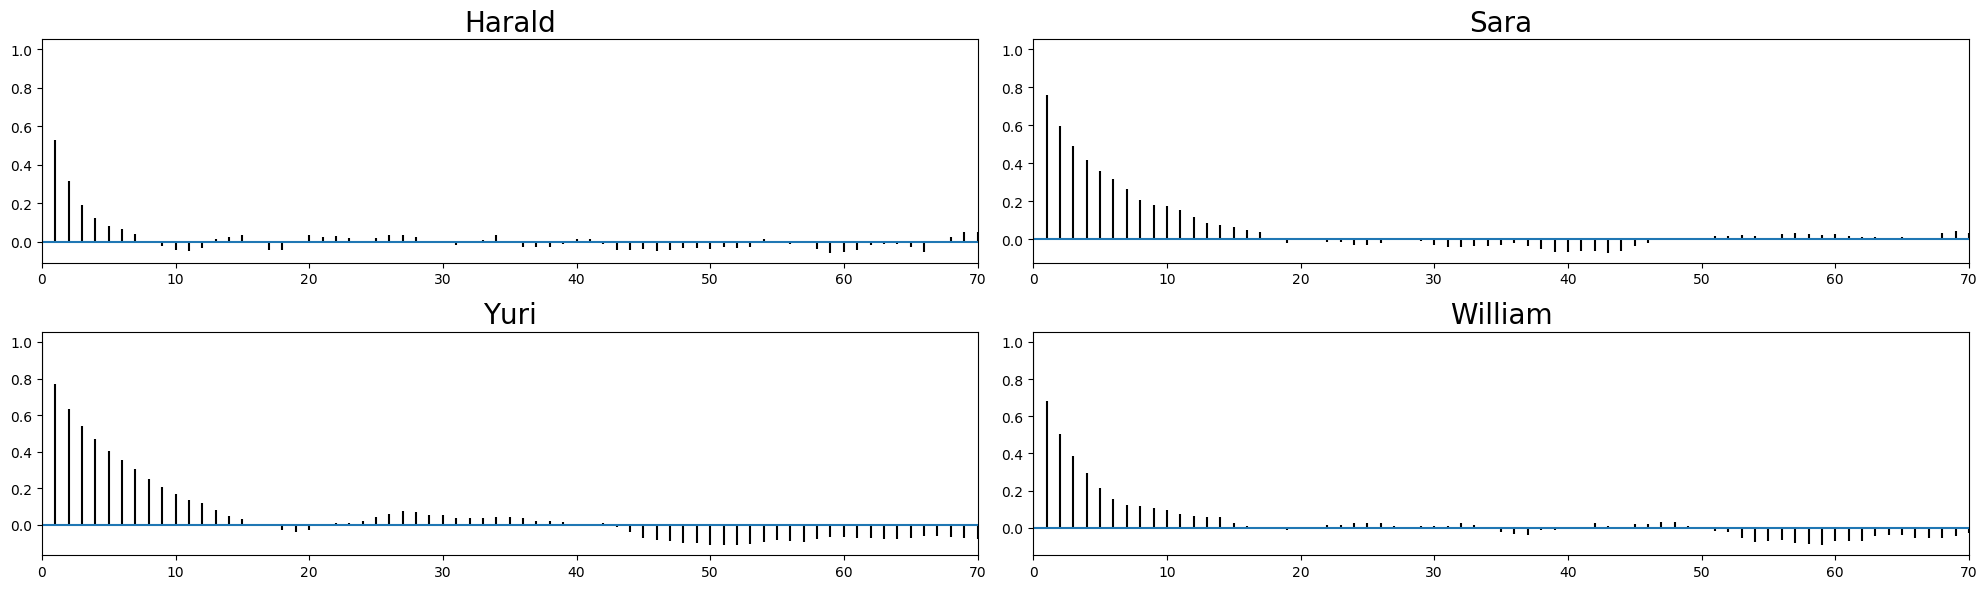

In [393]:
users = [0, 1, 2, 3]

with matplotlib.rc_context({'figure.figsize': [20,6], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)  # 2 rows of panels, 3 columns
        fig.tight_layout()
        ax.acorr(single_trait_user_preferences_samples[:, users[i]] - np.mean(single_trait_user_preferences_samples[:, users[i]]), maxlags=70)
        ax.set_title(users_df.get_value(users[i], 'name'))
        ax.set_xlim(0,70)
plt.show()

Conversely, the mixing time is given by the time required for the samples to become uncorrelated. By looking at the autocorrelation plots, we can say that the mixing time is about 15-20 iterations.

# Ranked user preferences 

In [ ]:
mean_preferences = np.mean(user_preferences_samples[50:], axis=0)[:100]
std_preferences = np.std(user_preferences_samples[50:], axis=0)[:100]
rank_order = np.argsort(mean_preferences)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(100)
    plt.bar(x, mean_preferences[rank_order], align='center', width=.8, yerr=std_preferences[rank_order], color='green')
    plt.xticks(x, users_df.iloc[rank_order]['name'].values, rotation=-90, ha='right')
    plt.ylabel('user preferences')
plt.show()

# Ranked restaurant traits

In [ ]:
mean_traits = np.mean(restaurant_traits_samples[50:], axis=0)[:100]
std_traits = np.std(restaurant_traits_samples[50:], axis=0)[:100]
rank_order = np.argsort(mean_traits)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(100)
    plt.bar(x, mean_traits[rank_order], align='center', width=.8, yerr=std_traits[rank_order], color='red')
    plt.xticks(x, restaurants_df.iloc[rank_order]['name'].values, rotation=-90, ha='right')
    plt.ylabel('restaurant traits')
plt.show()

# Scatter plot user preferences and restaurant traits on the trait line

In [ ]:
plt.scatter(mean_traits[:20], np.zeros(20), color='red')
plt.scatter(mean_preferences[:20], np.zeros(20), color='blue')
plt.show()

# Modeling multiple traits and a binary outcome

In [ ]:
def compute_precision_for_restaurants(K, id, traits, reviews):
    precision = np.zeros(shape=(K,K))
    restaurant_reviews = np.where((reviews[:, 1] == id))[0]

    for i in range(restaurant_reviews.shape[0]):
        precision = precision + np.outer(traits[reviews[restaurant_reviews[i], 0]], 
                                         traits[reviews[restaurant_reviews[i], 0]])
    
    return precision

def compute_mean_of_posterior_for_restaurants(K, id, traits, reviews, user_experience):
    mean = np.zeros(K)
    restaurant_reviews = np.where((reviews[:, 1] == id))[0]
    
    for i in range(restaurant_reviews.shape[0]):
        mean = mean + user_experience[restaurant_reviews[i]] * traits[reviews[restaurant_reviews[i], 0]]

    return mean

def compute_precision_for_users(K, id, traits, reviews):
    precision = np.zeros(shape=(K,K))
    user_reviews = np.where((reviews[:, 0] == id))[0]

    for i in range(user_reviews.shape[0]):
        precision = precision + np.outer(traits[reviews[user_reviews[i], 1]], 
                                         traits[reviews[user_reviews[i], 1]])
    return precision

def compute_mean_of_posterior_for_users(K, id, traits, reviews, user_experience):
    mean = np.zeros(K)
    user_reviews = np.where((reviews[:, 0] == id))[0]
    
    for i in range(user_reviews.shape[0]):
        mean = mean + user_experience[user_reviews[i]] * traits[reviews[user_reviews[i], 1]]

    return mean

In [ ]:
def Gibbs_sampling_multiple_traits_binary_rating(reviews, K):

    pv_t = np.ones(shape=(R, K))   # prior variance for restaurant traits
    t = np.zeros((R, K))     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = np.ones((U, K))   # prior variance for user preferences
    p = np.zeros((U, K))     # user preferences, initialized to be the prior mean mu_0 = 0

    x = np.zeros(reviews.shape[0]) 
    
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(3500):
        
        if (num%100==0):
            print (num)
        
        # Sample user experience (x) given user preferences (p), restaurant traits (t) and rating (y)
        for r in range(reviews.shape[0]):
            s = np.dot(p[reviews[r][0]], t[reviews[r][1]])
            x[r] = rejection_sampling(s, 1, reviews[r][2])
            
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(shape=(R, K)) 
        for i in range(R):
            sigma_inv = np.diag(1./pv_t[i]) + compute_precision_for_restaurants(K, i, p, reviews)  
            sigma = np.linalg.inv(sigma_inv)
            mu_tilde = compute_mean_of_posterior_for_restaurants(K, i, p, reviews, x) 
            mu = np.dot(sigma, mu_tilde)
            t[i] = np.random.multivariate_normal(mean=mu, cov=sigma)
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(shape=(U, K))  
        for i in range(U):
            sigma_inv = np.diag(1./pv_p[i]) + compute_precision_for_users(K, i, t, reviews) 
            sigma = np.linalg.inv(sigma_inv)
            mu_tilde = compute_mean_of_posterior_for_users(K, i, t, reviews, x) 
            mu = np.dot(sigma, mu_tilde)
            p[i] = np.random.multivariate_normal(mean=mu, cov=sigma)

        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)

    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return restaurant_traits_samples, user_preferences_samples

In [ ]:
#multiple_traits_restaurant_traits_samples, multiple_traits_user_preferences_samples = Gibbs_sampling_multiple_traits_binary_rating(train_reviews, 2)

In [ ]:
restaurants_vary_num_traits = []
users_vary_num_traits = []

for i in range(1, 11):
    multiple_traits_restaurant_traits_samples, multiple_traits_user_preferences_samples = Gibbs_sampling_multiple_traits_binary_rating(train_reviews, i)
    restaurants_vary_num_traits.append(multiple_traits_restaurant_traits_samples)
    users_vary_num_traits.append(multiple_traits_user_preferences_samples)
    


In [ ]:
ndcg = []
accuracy = []

for i in range(10):
    
    ndcg_score = normalized_discounted_cumulative_gain(test_reviews, restaurants_vary_num_traits[i], users_vary_num_traits[i])
    accuracy_score = compute_accuracy(test_reviews, restaurants_vary_num_traits[i], users_vary_num_traits[i])
    
    print (ndcg_score)
    print (accuracy_score)
    
    ndcg.append(ndcg_score)
    accuracy.append(accuracy_score)
    

In [ ]:
x = np.arange(1, 11, step=1)
plt.style.use('default')
sns.set_style("whitegrid", {'legend.frameon':True})

with matplotlib.rc_context({'figure.figsize': [7.5,5], 'xtick.labelsize': 12, 'ytick.labelsize': 12}):
    plt.bar(x, accuracy, label='Accuracy')
    #plt.legend(loc='upper center', ncol=4, fontsize='x-large')
    
    plt.xticks(x,ha='right', fontsize='x-large')
    plt.ylabel('Accuracy', fontsize='x-large')
    plt.xlabel('Number of traits', fontsize='x-large')
    
    plt.ylim([0,1])

plt.savefig('accuracy.pdf')    
plt.show()x = np.arange(1, 11, step=1)
plt.style.use('default')
sns.set_style("whitegrid", {'legend.frameon':True})

with matplotlib.rc_context({'figure.figsize': [7.5,5], 'xtick.labelsize': 12, 'ytick.labelsize': 12}):
    plt.bar(x, ndcg, label='NDCG', color=sns.xkcd_rgb["medium green"])
    #plt.legend(loc='upper center', ncol=4, fontsize='x-large')
    
    plt.xticks(x,ha='right', fontsize='x-large')
    plt.ylabel('NDCG@5', fontsize='x-large')
    plt.xlabel('Number of traits', fontsize='x-large')
    
    plt.ylim([0,1])

plt.savefig('ndcg.pdf')    
plt.show()

# Compute variance of traits

In [ ]:
for i in range(10):
    std_user_traits = np.std(users_vary_num_traits[i][50:], axis=0)
    #print(np.where(std_user_traits < 0.5)[0].shape)
    std_restaurant_traits = np.std(restaurants_vary_num_traits[i][50:], axis=0)
    count = 0 
    for std in std_user_traits:
        cond = True
        #print (std)
        for j in range(i+1):
            if std[j] > 0.8:
                cond = False
        if cond is True:
            count = count + 1

    print (count)

    

In [ ]:
def compute_like_probability(user, restaurant, user_preferences_samples, restaurant_traits_samples):
    num_samples = 5000
    prob = 0
    for i in range(num_samples):
        idx = np.random.randint(3500, size=1)[0]
        restaurant_trait = restaurant_traits_samples[idx][restaurant]
        user_preference = user_preferences_samples[idx][user]
        experience = np.dot(user_preference,restaurant_trait)
        if experience > 0:
            prob +=1
    prob = float(prob)/float(num_samples)
    return prob

In [ ]:
import math

def normalized_discounted_cumulative_gain(test_reviews, restaurant_traits_samples, user_preferences_samples):
    num_test_reviews = test_reviews.shape[0]
    ndcg = 0.0
    for user in range(U):
        like_probability = []
        user_reviews = reviews[np.where((test_reviews[:, 0] == user))[0]]
        if(user_reviews.shape[0] == 0):
            continue
        restaurants = user_reviews[:, 1]
        for restaurant in restaurants:
            like_probability.append(compute_like_probability(user, restaurant, user_preferences_samples, restaurant_traits_samples))
        like_probability = np.array(like_probability)
        rank_order = np.flip(np.argsort(like_probability), axis=0)
        
        like_probability =  like_probability[rank_order]
        user_reviews = user_reviews[rank_order]
        
        score = 0.0
        normalization_score = 0.0
        
        top_stars = np.flip(np.sort(user_reviews[:, 2]), axis=0)[:5]
        
        discount_factor = [1.0, 0.63, 0.5, .43, .39]
        for i in range(min(top_stars.shape[0], 5)):
            score = score + discount_factor[i] * float(user_reviews[i][2])                                            
            normalization_score = normalization_score + discount_factor[i] * float(top_stars[i])
            
        ndcg = ndcg + (score/normalization_score)
    
    return ndcg/U
    
normalized_discounted_cumulative_gain(test_reviews, restaurants_vary_num_traits[4], users_vary_num_traits[4])

# Evaluate accuracy of predicting correct rating on test reviews 

In [ ]:
def compute_accuracy(test_reviews, restaurant_traits_samples, user_preferences_samples):
    num_test_reviews = test_reviews.shape[0]
    num = 0
    num_samples=100
    for test_review in test_reviews:
        user = test_review[0]
        restaurant = test_review[1]

        prob = compute_like_probability(user, restaurant, user_preferences_samples, restaurant_traits_samples)
        if prob>=0.5:
            experience = 1
        else:
            experience = -1
        if test_review[2] > 3:
            sign = 1
        else:
            sign = -1

        if experience == sign:
            num = num + 1

    return (float(num)/float(num_test_reviews))
  


# Burn-in time for Gibbs sampler

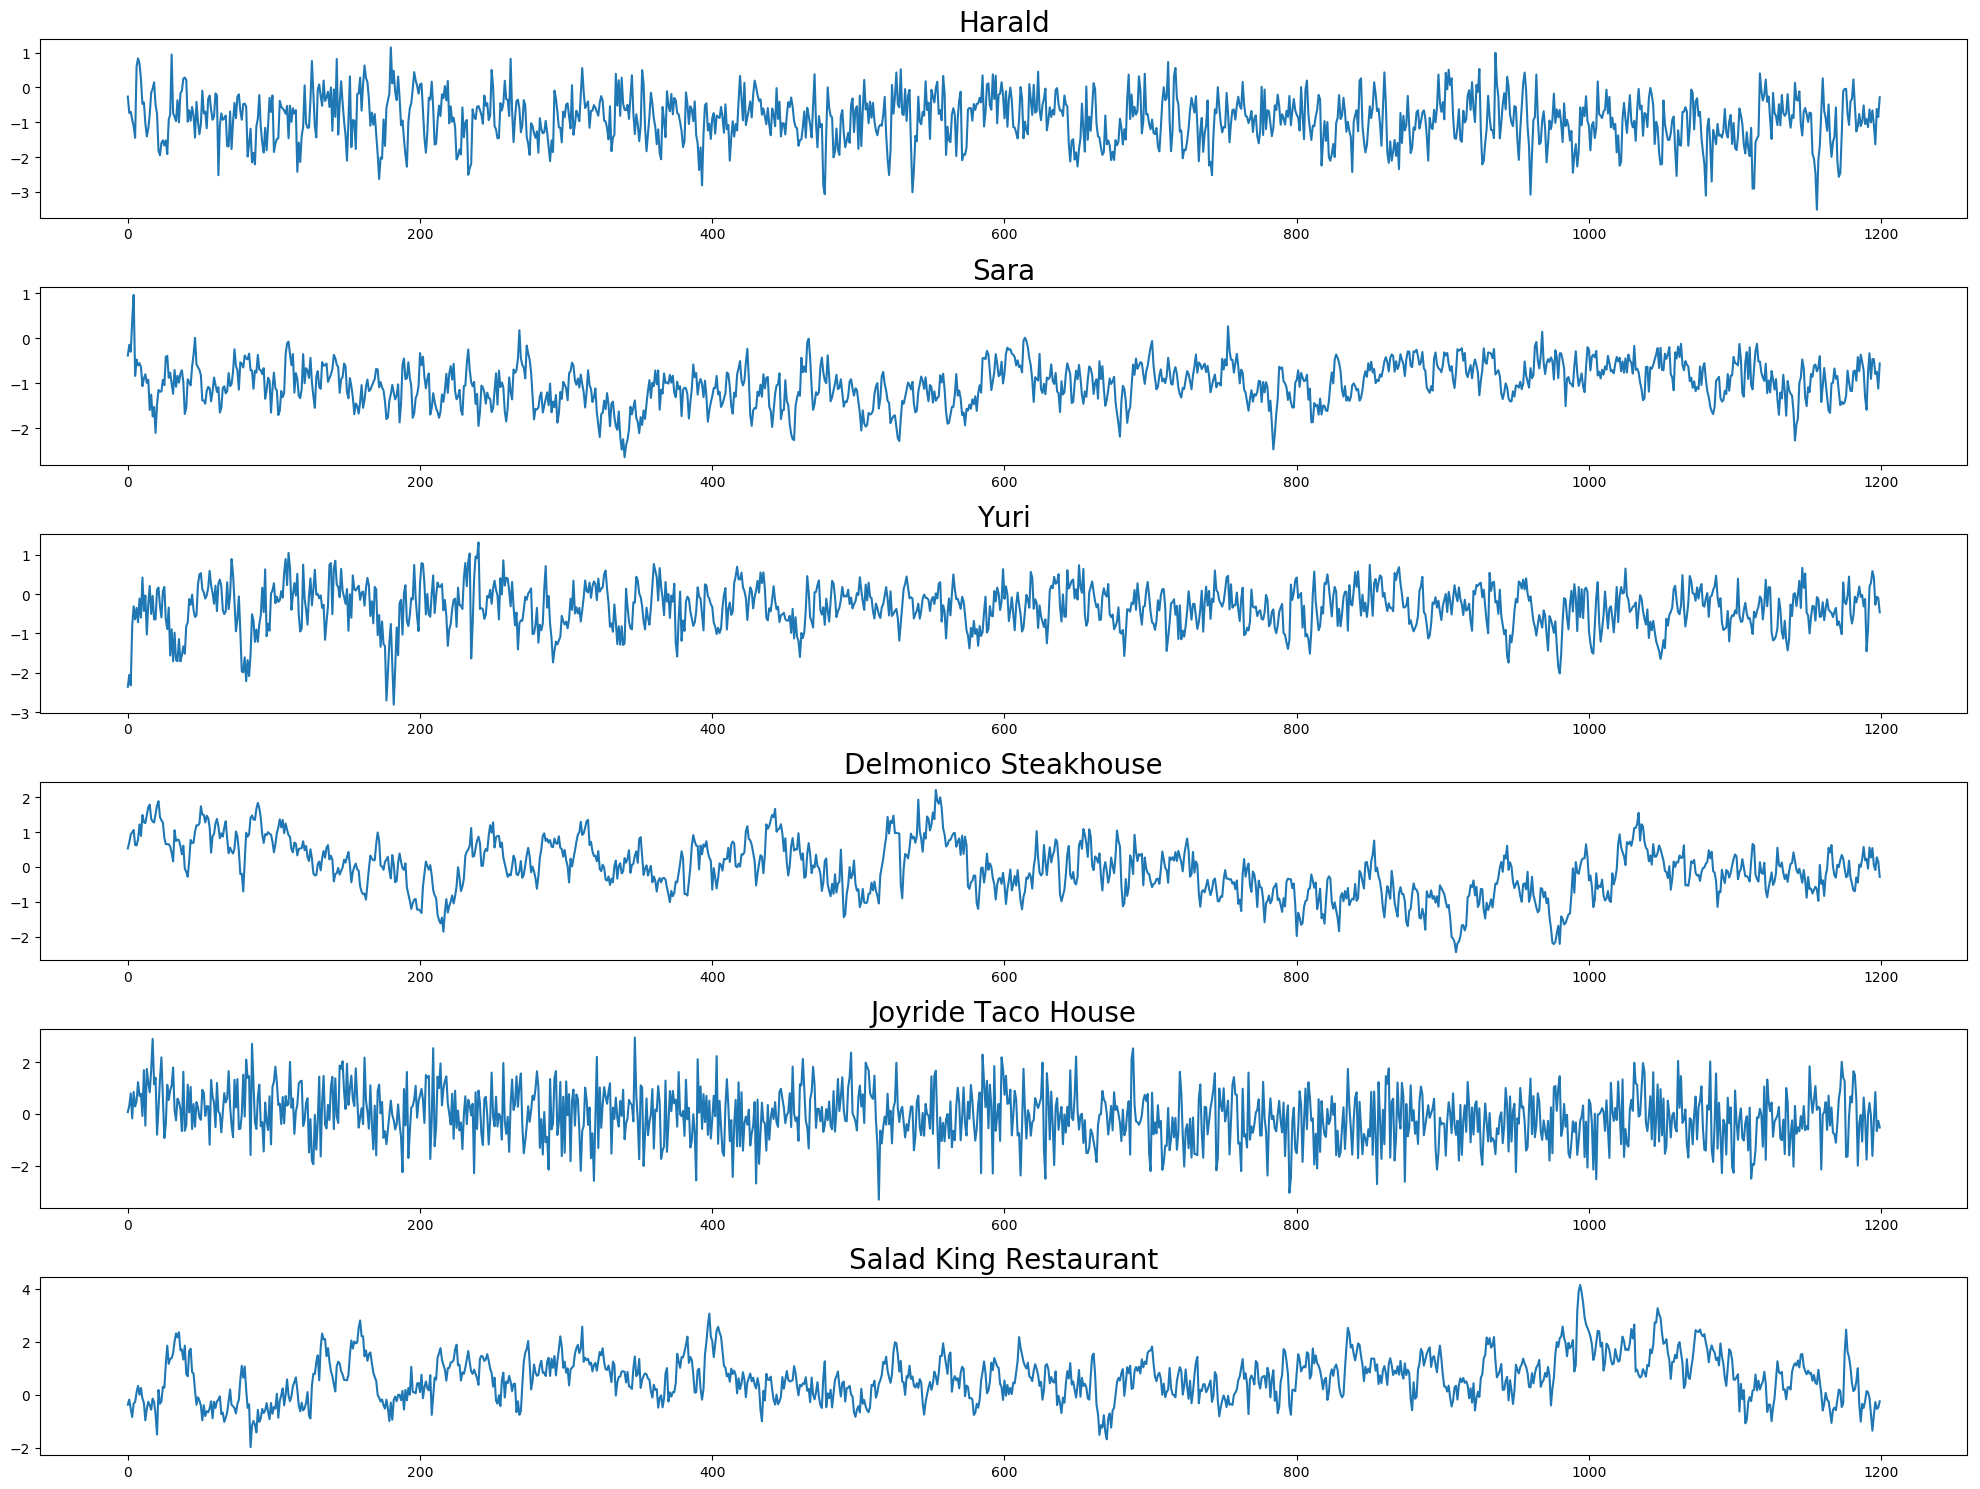

In [412]:
users = [0, 1, 2]
restaurants = [0, 1, 2]

with matplotlib.rc_context({'figure.figsize': [20,15], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+1)
        fig.tight_layout()
        fig.tight_layout()
        ax.plot(users_vary_num_traits[1][:1200, users[i], 0])
        ax.set_title(users_df.get_value(users[i], 'name'))
    for i in range(3):
        ax = fig.add_subplot(6, 1, i+4)
        fig.tight_layout()
        ax.plot(restaurants_vary_num_traits[2][:1200, restaurants[i], 0])
        ax.set_title(restaurants_df.get_value(restaurants[i], 'name'))
plt.show()

The burning time represents the time required to get from the initial random location in the Gibbs sampler to a location that has a high probability under the posterior. By looking at the user preferences and restaurant traits for each iteration we can notice that the burning time is about 40 iterations. 

# Mixing time for Gibbs sampler

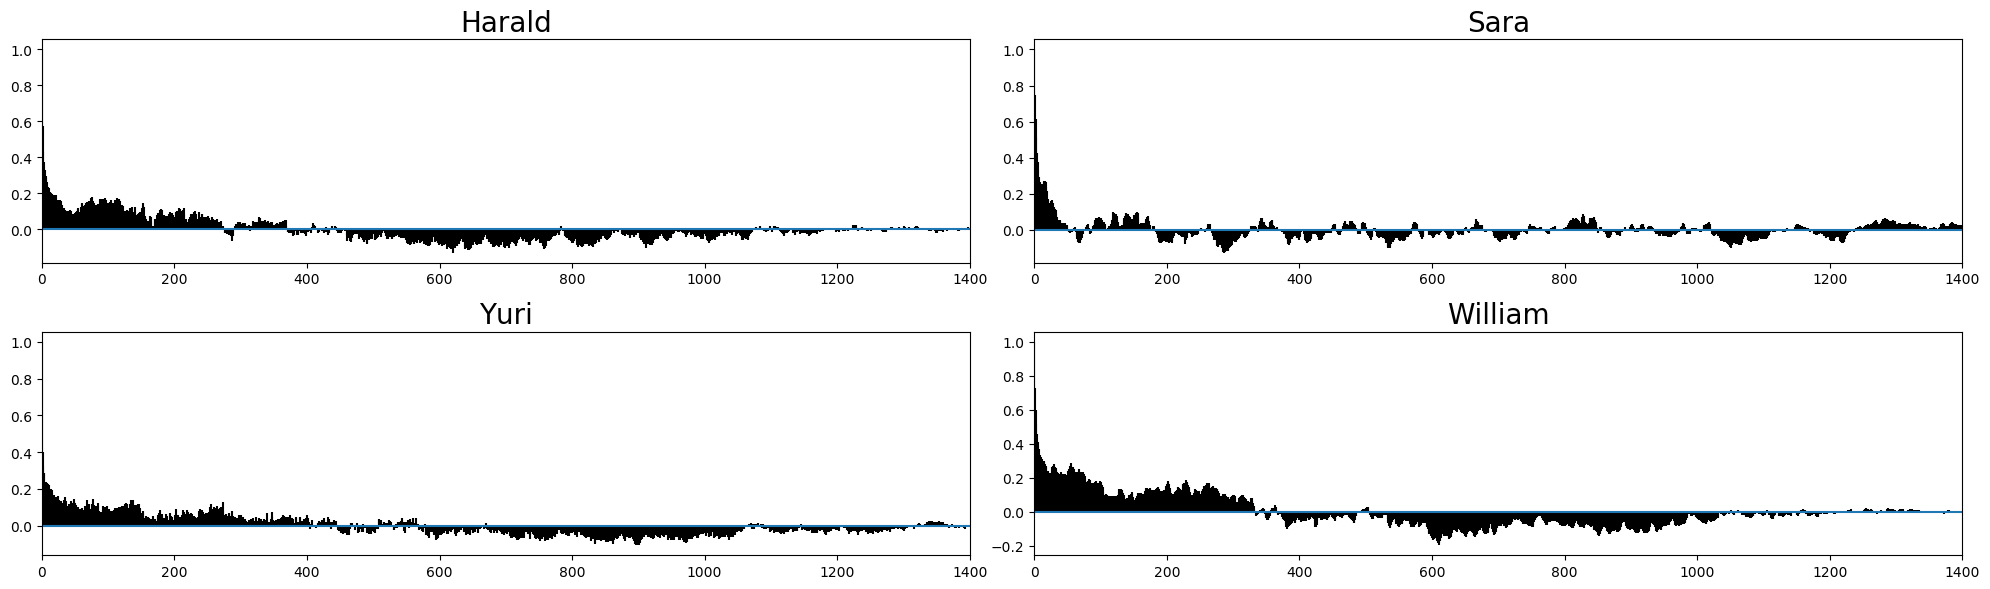

In [415]:
users = [0, 1, 2, 3]

with matplotlib.rc_context({'figure.figsize': [20,6], 'axes.titlesize': 20}):
    fig = plt.figure()
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)  # 2 rows of panels, 3 columns
        fig.tight_layout()
        ax.acorr(users_vary_num_traits[7][:, users[i]][:,1] - np.mean(users_vary_num_traits[7][:, users[i]][:,1]), maxlags=1400)
        ax.set_title(users_df.get_value(users[i], 'name'))
        ax.set_xlim(0,1400)
plt.show()

# Scatter plot user preferences and restaurant traits on the trait line

In [389]:
mean_traits = np.mean(multiple_traits_restaurant_traits_samples[50:], axis=0)
mean_preferences = np.mean(multiple_traits_user_preferences_samples[50:], axis=0)

for index, mean_trait in enumerate(mean_traits):
    if (mean_traits[index][0] < -1.4) and (mean_traits[index][0] > -1.5):
        west = index
    if mean_traits[index][0] > 1.8:
        east = index
    if mean_traits[index][1] > 1.5:
        north = index
    if mean_traits[index][1] >1 and mean_traits[index][0] > 0.75:
        north_east = index
        
    if restaurants_df.iloc[index]['name'] == 'Taco Guild':
        south_east = index
        
    if mean_traits[index][0] < -0 and mean_traits[index][0] > -0.5 and mean_traits[index][1] < -0.4 and mean_traits[index][1] > -0.5:
        south_west = index        
        
print (east)
print (restaurants_df.iloc[east]['name'])
print (restaurants_df.iloc[east]['id'])

print (west)
print (restaurants_df.iloc[west]['name'])
print (restaurants_df.iloc[west]['id'])

print (north)
print (restaurants_df.iloc[north]['name'])
print (restaurants_df.iloc[north]['id'])

print (north_east)
print (restaurants_df.iloc[north_east]['name'])
print (restaurants_df.iloc[north_east]['id'])

print (south_east)
print (restaurants_df.iloc[south_east]['name'])
print (restaurants_df.iloc[south_east]['id'])

print (south_west)
print (restaurants_df.iloc[south_west]['name'])
print (restaurants_df.iloc[south_west]['id'])



331
Raku
sqRX-XLlhx4rs2c1TpBf8A
280
Umami Burger -  SLS Las Vegas
PbyqDJf815zRn-7p6vYpAQ
357
The Palazzo Las Vegas
uGupeWqih0yIcCg8anM1PA
426
KoMex Fusion
zdE82PiD6wquvjYLyhOJNA
25
Taco Guild
3C5Z9homtzkWHouH2BHXYQ
353
Treasure Island
uanCi4OGc1mHLGl_AT4JhQ


In [ ]:
plt.style.use('default')
#sns.set_style("white")
mean_traits = np.mean(multiple_traits_restaurant_traits_samples[50:], axis=0)
mean_preferences = np.mean(multiple_traits_user_preferences_samples[50:], axis=0)

with matplotlib.rc_context({'figure.figsize': [12,5], 'xtick.labelsize': 12, 'ytick.labelsize': 12}):
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    #ax.set_xlabel(fontsize='20')
    ax.yaxis.set_ticks_position('left')

    
    
    plt.scatter(mean_preferences[:, 0], mean_preferences[:, 1], color=sns.xkcd_rgb["medium green"], label='Users')
    plt.scatter(mean_traits[:, 0], mean_traits[:, 1], color=sns.xkcd_rgb["pale red"], label = 'Restaurants')
    plt.xlim([-2, 2])
    plt.ylim([-3, 3])
    
    ax.annotate('Raku', fontsize='large', 
                xy=(mean_traits[east][0],mean_traits[east][1]), xytext=(1.7, -1), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('Umami Burger', fontsize='large',
                xy=(mean_traits[west][0],mean_traits[west][1]), xytext=(-2, 1.2), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('Citizens Kitchen', fontsize='large',
                xy=(mean_traits[north][0],mean_traits[north][1]), xytext=(-0.75, 2.5), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('Citizens Kitchen', fontsize='large',
                xy=(mean_traits[north][0],mean_traits[north][1]), xytext=(-0.75, 2.5), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('KoMex Fusion', fontsize='large',
                xy=(mean_traits[north_east][0],mean_traits[north_east][1]), xytext=(0.75, 2.5), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    ax.annotate('Brasserie', fontsize='large',
                xy=(mean_traits[south_west][0],mean_traits[south_west][1]), xytext=(-0.7, -2), 
                arrowprops=dict(facecolor='black', arrowstyle="fancy"))
    
    
    
    plt.legend(loc='lower right', fontsize='x-large')

    
plt.savefig('traits_restaurants.pdf')    
plt.show()

Considering that there are more reviews with postive rankings, the points in the trait space are on the positive side. 

In [ ]:
multiple_traits_restaurant_traits_samples[1][1].shape

# Modeling single trait and star ratings

In [ ]:
def rejection_sampling_user_experience(mu, std, rating, threshold):
    while True:
        x = np.random.normal(loc=mu, scale=std)
        cond = True        
        for i in range(1, rating+1):
            if (np.sign(x-threshold[i]) == -1):
                cond = False
        for i in range(rating+1, 6):
            if (np.sign(x-threshold[i]) == 1):
                cond = False
        if cond:
            return x

def rejection_sampling_star_threshold(star, x, reviews, mu, std):
    while True:
        threshold = np.random.normal(loc=mu, scale=std)
        cond = True
        for i in range (star, 6):
            if (-1 in ((np.sign(x-threshold)) * (reviews[:, 2]==i).astype(int))):
                cond = False
        for i in range (1, star):
            if (1 in ((np.sign(x-threshold)) * (reviews[:, 2]==i).astype(int))):
                cond = False
        if cond:
            return threshold

In [ ]:
def Gibbs_sampling_single_trait_star_rating(reviews):

    pv_t = 1 * np.ones(R)   # prior variance for restaurant traits
    t =  np.zeros(R)     # restaurant traits, initialized to be the prior mean mu_0 = 0

    pv_p = 1 * np.ones(U)   # prior variance for user preferences
    p = np.zeros(U)     # user preferences, initialized to be the prior mean mu_0 = 0
    
    pv_h = 10 * np.ones(6) 
    pm_h = [0, -2, -1, 0, 1, 2]
    
    h = [0, -2, -1, 0, 1, 2]
    
    x = np.zeros(reviews.shape[0]) 
    
    star_threshold_samples = []
    restaurant_traits_samples = []
    user_preferences_samples = []

    for num in range(200):
        
        print (num)
        
        # Sample user experience (x) given user preferences (p), restaurant traits (t), star thresholds (h) and rating (y)
        for r in range(reviews.shape[0]):
            s = p[reviews[r][0]] * t[reviews[r][1]]
            x[r] = rejection_sampling_user_experience(s, 1, reviews[r][2], h)  
        
        print (x)
        # Sample star thresholds h2, h4 and h5 given user preferences (p), restaurant traits (t), user_experiences (x) and rating (y)
        h = np.zeros(6) 
        for i in range (1, 6):
            h[i] = rejection_sampling_star_threshold(i, x, reviews, pm_h[i], pv_h[i])
        print (h)
        
        # Sample each restaurant trait (t) given user experiences (x)
        t = np.zeros(R) 
        for i in range(R):
            var_inv = 1/pv_t[i] + (np.square(p[reviews[:, 0]]) * (reviews[:, 1]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * p[reviews[:,0]] * ((reviews[:, 1] == i).astype(int))).sum() 
            mu = var * mu_tilde
            t[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
        
    
        # Sample user preferences (p) given user experience (x)
        p = np.zeros(U)  
        for i in range(U):
            var_inv = 1/pv_p[i] + (np.square(t[reviews[:, 1]]) * (reviews[:, 0]==i).astype(int)).sum() 
            var = 1/var_inv
            mu_tilde = (x * t[reviews[:,1]] * ((reviews[:, 0] == i).astype(int))).sum() 
            mu = var * mu_tilde
            p[i] = np.random.normal(loc=mu, scale=np.sqrt(var))
            

        star_threshold_samples.append(h)
        restaurant_traits_samples.append(t)
        user_preferences_samples.append(p)
           

    star_threshold_samples = np.array(star_threshold_samples)
    restaurant_traits_samples = np.array(restaurant_traits_samples)
    user_preferences_samples = np.array(user_preferences_samples)
    
    return star_threshold_samples, restaurant_traits_samples, user_preferences_samples

In [ ]:
star_threshold_samples, restaurant_traits_samples, user_preferences_samples = Gibbs_sampling_single_trait_star_rating(train_reviews)

In [ ]:
star_threshold_samples = np.loadtxt("star_threshold_samples.txt")
star_restaurant_traits_samples = np.loadtxt("restaurant_traits_samples.txt")
star_user_preferences_samples = np.loadtxt("user_preferences_samples.txt")

In [ ]:
std_star_restaurant_traits_samples = np.std(star_restaurant_traits_samples, axis=0)
std_star_user_traits_samples = np.std(star_user_preferences_samples, axis=0)
print(np.where(std_star_restaurant_traits_samples < 0.8)[0].shape)
print(np.where(std_star_user_traits_samples < 0.8)[0].shape)

In [ ]:
import matplotlib.mlab as mlab

mean_stars = np.mean(star_threshold_samples, axis=0)
std_stars = np.std(star_threshold_samples, axis=0)
plt.style.use('seaborn')
sns.set_style("whitegrid")
print (mean_stars)
print (std_stars)

mu=mean_stars[3]
sigma = std_stars[3] ** 2

with matplotlib.rc_context({'figure.figsize': [7,4.5], 'xtick.labelsize': 8}):
    for i in range(4):

        mu=mean_stars[i+2]
        sigma = std_stars[i+2]

        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
        plt.plot(x,mlab.normpdf(x, mu, sigma), label="Star " + str(i+2))
        plt.ylim([-3, 175])

plt.ylabel('$p(x)$', fontsize='large')
plt.xlabel('$x$', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.legend(loc='upper center', ncol=4, fontsize='large')
plt.savefig('star_thresholds.pdf')
plt.show()

# Ranked user preferences 

In [ ]:
users=[7, 115, 363, 560, 300]
users_names = [7, 100, 363, 560, 300, 140]

mean_single_preferences = np.mean(single_trait_user_preferences_samples[:, users], axis=0)
std_single_preferences = np.std(single_trait_user_preferences_samples[:, users], axis=0)

mean_multiple_preferences = np.mean(multiple_traits_user_preferences_samples[:, users], axis=0)[:,0]
std_multiple_preferences = np.std(multiple_traits_user_preferences_samples[:, users], axis=0)[:,0]

mean_star_preferences = np.mean(star_user_preferences_samples[:, users], axis=0)
std_star_preferences = np.std(star_user_preferences_samples[:, users], axis=0)
#rank_order = np.argsort(mean_preferences)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,20], 'xtick.labelsize': 14}):
    fig = plt.figure()
    x = np.arange(len(users))
    
    ax = fig.add_subplot(3, 3, 1)
    #fig.tight_layout()
    
    ax.bar(x, mean_single_preferences, align='center', width=.8, yerr=std_single_preferences, color='green')
    ax.set_xticklabels(users_df.iloc[users_names]['name'].values)
    ax.set_ylabel('user preferences (single trait)', fontsize='xx-large')
    ax.set_ylim([-0.8, 2.1])
    
    ax = fig.add_subplot(3, 3, 2)
    #fig.tight_layout()
    
    ax.bar(x, mean_multiple_preferences, align='center', width=.8, yerr=std_multiple_preferences, color=sns.xkcd_rgb["pale red"])
    ax.set_xticklabels(users_df.iloc[users_names]['name'].values)
    ax.set_ylabel('user preferences (multiple traits)', fontsize='xx-large')
    ax.set_ylim([-0.8, 2.1])
    
    ax = fig.add_subplot(3, 3, 3)
    #fig.tight_layout([-0.8, 2])
    
    ax.bar(x, mean_star_preferences, align='center', width=.8, yerr=std_star_preferences, color=sns.xkcd_rgb["medium green"])
    ax.set_xticklabels(users_df.iloc[users_names]['name'].values)
    ax.set_ylabel('user preferences (star ratings)', fontsize='xx-large')
    ax.set_ylim([-0.8, 2.1])
    
plt.savefig('user_preferences_variance.pdf') 
plt.show()

In [ ]:
users_df.iloc[users]['name'].values

In [ ]:
import math
def compute_confusion_matrix(test_reviews, star_threshold_samples, star_user_preferences_samples, star_restaurant_traits_samples):
    num_test_reviews = test_reviews.shape[0]
    num = 0
    error = 0
    num_samples=1000
    confusion_matrix = np.zeros(shape=(5, 5))
    for test_review in test_reviews:
        user = test_review[0]
        restaurant = test_review[1]
        actual_star = test_review[2]-1

        prob = np.zeros(5)
        for i in range(num_samples):
            idx = np.random.randint(200, size=1)[0]
            restaurant_trait = star_restaurant_traits_samples[idx][restaurant]
            user_preference = star_user_preferences_samples[idx][user]
            star_thresholds = star_threshold_samples[idx]
            experience = user_preference * restaurant_trait
            
            for i in range(5):
                if experience > star_thresholds[i+1]:
                    prob[i] +=1
            
            
        #print (experience)
        prob = prob.astype(float)/float(num_samples)
        #print (prob)
        for i in range(4):
            prob[i] = prob[i]-prob[i+1]

        #print (prob)
        
        predicted_star = np.argmax(prob)
        
        #print (predicted_star)
        #print (actual_star)
        confusion_matrix[actual_star][predicted_star] +=1
        error = error + math.fabs(actual_star - predicted_star)

    return confusion_matrix, error/num_test_reviews

confusion_matrix, error =compute_confusion_matrix(test_reviews, star_threshold_samples, 
                                                  star_user_preferences_samples, star_restaurant_traits_samples)

In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

sn.reset_orig()

def plot_confussion_matrix_as_heatmap(confussion_matrix):
    with matplotlib.rc_context({'figure.figsize': [17,40], 'xtick.labelsize': 8}):
        fig = plt.figure()
        confussion_matrix = np.array(confussion_matrix)
        new_confussion_matrix = confussion_matrix

        labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

        df_cm = pd.DataFrame(confussion_matrix, index=[i for i in labels], columns=[i for i in labels])

        fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
        sn.heatmap(df_cm, annot=True, ax=ax, cbar=False, fmt="d", annot_kws={"size": 20})

        ax.xaxis.set_ticks_position('top')
        plt.yticks(rotation=0, size=18)
        plt.xticks(rotation=0, size=18)

        plt.xlabel('Predicted star rating', size=18)
        ax.xaxis.set_label_coords(0.5, 1.1)

        plt.ylabel('Actual star rating', size=18)
    
    plt.savefig('stars_confussion_matrix.pdf')
    plt.show()

    
plot_confussion_matrix_as_heatmap(confusion_matrix.astype(int))  
